### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
from keras.datasets import mnist # MNIST dataset is included in Keras

2023-09-19 02:40:39.363098: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-19 02:40:39.438137: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-19 02:40:39.439191: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-19 02:40:40.324378: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


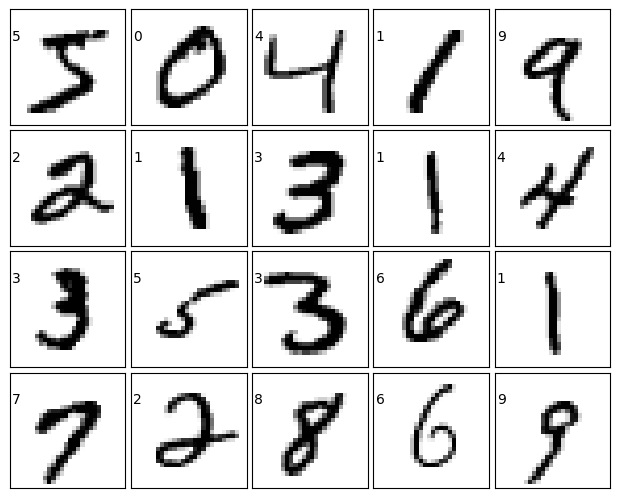

In [5]:
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(20):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train[i], cmap=plt.cm.binary, interpolation='nearest')
    # label the image with the target value
    ax.text(0, 7, str(y_train[i]))

In [6]:
# Reshaping the dataset
X_train = X_train.reshape(60000, 784) 
X_test = X_test.reshape(10000, 784)  

# Change integers to 32-bit floating point numbers
X_train = X_train.astype('float32')   
X_test = X_test.astype('float32')

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


In [7]:
# Apply standarization to both train and test data
from sklearn.preprocessing import MinMaxScaler
X_train = MinMaxScaler().fit_transform(X_train)
X_test = MinMaxScaler().fit_transform(X_test)

In [8]:
from sklearn.manifold import TSNE

In [9]:
import time
t0 = time.time()
tsne = TSNE(n_components=2, random_state = 42)
x_transformed = tsne.fit_transform(X_train) 
t1 = time.time()
print("Tempo total em segundos para essa execução: ", t1 - t0)

Tempo total em segundos para essa execução:  481.22910165786743


/home/datascience/conda/automlx_p38_cpu_v5/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x800 with 0 Axes>

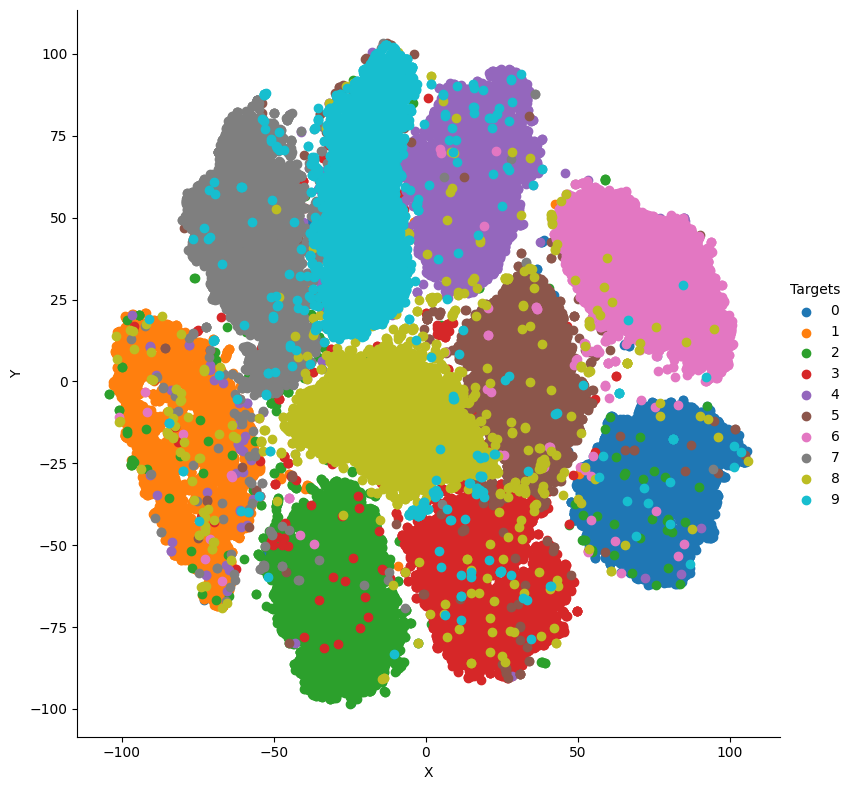

In [10]:
import seaborn as sn
# convert the transformed data into dataframe
tsne_df = pd.DataFrame(np.column_stack((x_transformed, y_train)), columns=['X', 'Y', "Targets"])
tsne_df.loc[:, "Targets"] = tsne_df.Targets.astype(int)
plt.figure(figsize=(10,8))
sn.FacetGrid(tsne_df, hue="Targets", height=8).map(plt.scatter, 'X', 'Y').add_legend()
plt.show()

In [11]:
#aplicando a transformação t-SNE nos conjuntos
train_img = x_transformed
test_img = tsne.fit_transform(X_test)

print(f'train_img shape : {train_img.shape}')
print(f'test_img shape : {test_img.shape}')

train_img shape : (60000, 2)
test_img shape : (10000, 2)


In [12]:
from sklearn.neural_network import MLPClassifier

In [13]:
clf = MLPClassifier(solver = 'lbfgs')

In [14]:
clf.fit(train_img, y_train)

/home/datascience/conda/automlx_p38_cpu_v5/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(solver='lbfgs')

In [15]:
print('Training score : ', clf.score(train_img, y_train))
print('Testing score  : ', clf.score(test_img, y_test))

Training score :  0.9522666666666667
Testing score  :  0.1751
